In [1]:
## Importing libraries
%matplotlib inline
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
from scipy.stats import norm, multivariate_normal, linregress
from scipy.integrate import trapz, quad

1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


In [2]:
#Seeding the random generator
np.random.seed(2009440)

0.8763532541332144
499.97165652440464


<Figure size 432x288 with 0 Axes>

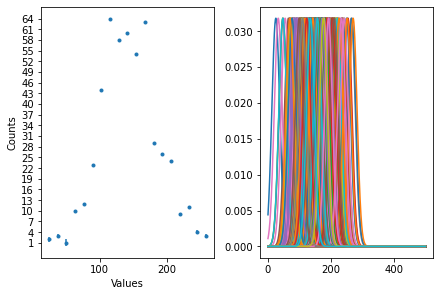

In [8]:
mean = 150
stdev = 40
N = np.linspace(0, 500, 10000)

x = np.random.normal(mean, stdev, int(N.max()))

counts, bins = np.histogram(x, bins = "auto")

plt.clf()
fig, (ax0, ax1)= plt.subplots(1,2, constrained_layout = True)

ax0.errorbar(bins[:len(bins)-1], counts, xerr = None, yerr=[1/np.sqrt(i) if i != 0 else i for i in counts], ls="", marker = ".", barsabove = True)
ax0.set_xlabel("Values")
ax0.set_ylabel("Counts")
ax0.set_yticks(range(min(counts), max(counts)+1, 3))
stdev = 1.06*x.std()*x.size**(-0.2)

gaussians = np.array([norm.pdf(N, i, stdev) for i in x])
for i in range(len(x)):
    ax1.plot(N, gaussians[i])
    
x_gauss = norm.fit(counts)
x_gauss = norm.pdf(N, x_gauss[0],x_gauss[1])
x_integral = trapz(x_gauss, x=N)
gauss_integral = trapz(gaussians, x=N)

print(x_integral)
print(np.sum(gauss_integral))

# 2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

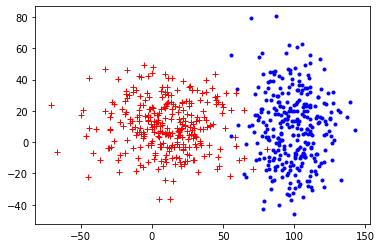

In [4]:
mean = 100, 10
stdev = 23, 15
N_points = 300
N_categories = 2

#I'll define a dictionary to make it easier to call each part of the dataset.

dataset = {'norm_x1': np.random.normal(mean[0], stdev[1], N_points), 'norm_y1': np.random.normal(mean[1], stdev[0], N_points), 'norm_x2': np.random.normal(mean[1], stdev[0], N_points), 'norm_y2':np.random.normal(mean[1], stdev[1], N_points)}

plt.plot(dataset["norm_x1"], dataset["norm_y1"], marker='.', color='blue', linestyle = "")
plt.plot(dataset["norm_x2"], dataset["norm_y2"], marker='+', color = 'red', linestyle = "")
plt.show()

In [5]:
mean = 5
for i in range(len(mean)):
    print(i)

TypeError: object of type 'int' has no len()

In [ ]:
!wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [ ]:
!wget -q https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy #using the -q "quiet" flag to suppress the output of this line

In [ ]:
# Separating cells to avoid downloading the file over and over
data = np.load('residuals_261.npy', allow_pickle = True).item()
data = pd.DataFrame(data, columns = data.keys())

clean_data = data.loc[abs(data['residuals']) < 2, list(data.columns)]
clean_data = clean_data.reset_index(drop = True)

linreg = linregress
slope, intercept, rval, pval, err = linreg(clean_data['distances'], clean_data['residuals'])

x_counts, x_bins = np.histogram(clean_data['distances'], bins = "auto")

y = [clean_data.loc[(clean_data['distances'] <= x_bins[i]) & (clean_data['distances'] >= x_bins[i-1]), ['residuals']].values.mean() for i in range(1,len(x_bins))]
yerr = [clean_data.loc[(clean_data['distances'] <= x_bins[i]) & (clean_data['distances'] >= x_bins[i-1]), ['residuals']].values.std() for i in range(1,len(x_bins))]
     
sns.set_theme(style = 'darkgrid')

#fig, ax = plt.subplots()
plot = sns.jointplot(x = 'distances', y = 'residuals', data = clean_data, kind = 'reg', ax=ax)
sns.scatterplot(data = y, marker = '+', color = '.2',ax = ax)
#fig2, ax2 = plt.subplots()
#sns.relplot(x = 'distances' data = y, )
# fig2 = plt.subplots()
# sns.histplot(data = clean_data["distances"], bins = x_bins, ax=fig2[1])

#fig3 = plt.subplots()
#sns.displot(y, ax=fig3[1])

In [ ]:
plot